# Run to Convert a New OBJ file to a TXT file

In [1]:
def obj_to_txt(model_directory: str, mesh_file: str) -> None:
    '''
    Takes in an OBJ mesh file and converts it into a text file.

    Parameters
    ----------
    model_directory : str
        The relative path to the folder that contains the UV mapped mesh files
        in obj format.
    mesh_file : str
        The file name of the obj mesh file.

    See Also
    --------
    txt_to_dataframe :
        Parses 3D mesh file in text format into the UV data and face lookup
        table.

    Notes
    -----
    For this text file to be useable in other code, the mesh needs to have a
    UV map that matches the location drawing template. The obj file was chosen
    because it does not change the mesh and is already in a space separated
    file format.

    The saved data has the format on each row:
    +----------------+----------+----------+----------+
    | Mesh Data Type | Column 1 | Column 2 | Column 3 |
    +----------------+----------+----------+----------+

    The vertex data looks like:
    +---+-----+-----+-----+
    | v | x1  | y1  | z1  |
    +---+-----+-----+-----+
    | v | x2  | y2  | z2  |
    +---+-----+-----+-----+
    | v | x3  | y3  | z3  |
    +---+-----+-----+-----+
    | v | ... | ... | ... |
    +---+-----+-----+-----+

    The UV data has the format:
    +----+-----+-----+
    | vt | x1  | y1  |
    +----+-----+-----+
    | vt | x2  | y2  |
    +----+-----+-----+
    | vt | x3  | y3  |
    +----+-----+-----+
    | vt | ... | ... |
    +----+-----+-----+

    The normal data has the format:
    +----+-----+-----+-----+
    | vn | x1  | y1  | z1  |
    +----+-----+-----+-----+
    | vn | x2  | y2  | z2  |
    +----+-----+-----+-----+
    | vn | x3  | y3  | z3  |
    +----+-----+-----+-----+
    | vn | ... | ... | ... |
    +----+-----+-----+-----+

    The face data has the format:
    +---+------------------+------------------+------------------+
    | f | v1,1/vt1,1/vn1,1 | v1,2/vt1,2/vn1,2 | v1,3/vt1,3/vn1,3 |
    +---+------------------+------------------+------------------+
    | f | v2,1/vt2,1/vn2,1 | v2,2/vt2,2/vn2,2 | v2,3/vt2,3/vn2,3 |
    +---+------------------+------------------+------------------+
    | f | v3,1/vt3,1/vn3,1 | v3,2/vt3,2/vn3,2 | v3,3/vt3,3/vn3,3 |
    +---+------------------+------------------+------------------+
    | f |       ...        |       ...        |       ...        |
    +---+------------------+------------------+------------------+
    '''
    # Opens the obj file to read from
    with open(f"{model_directory}/{mesh_file}.obj", "r") as obj_file:
        # creates the txt file to write to
        with open(f"{model_directory}/{mesh_file}.txt", "w") as txt_file:
            for line in obj_file:
                # Eliminates all lines that are not mesh data. These lines
                # start with v, vt, vn, f for vertex, UVs, normals, face data.
                if line[0] == 'v' or line[0] == 'f':
                    txt_file.write(f"{line}")

In [2]:
files = ["Male Right Base Map", "Male Right Moved Elbow Map",
         "Male Left Base Map", "Male Left Moved Elbow Map"]
for file in files:
    obj_to_txt("../Models/Adjusted Elbow", file)

# Run to Remove Mesh Points Off of a UV Map

## Imports

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import potpourri3d as pp3d
import numpy as np
from typing import List, Tuple

## Divide imported obj text file as a dataframe

In [4]:
def txt_to_dataframe(model_directory: str,
                     file_name: str) -> Tuple[pl.DataFrame, pl.DataFrame]:
    '''
    Parses 3D mesh file in text format into the UV data and face lookup table.

    Takes in the text file created from the OBJ file of the male or female,
    right or left arm and returns the UV data and a table extracted from the
    face data. The UV data corresponds to the location template the subject
    drew on. The table from the face data serves as a lookup table between
    the UV data and their corresponding vertex in the 3D mesh.

    Parameters
    ----------
    model_directory : str
        The relative path to the folder that contains the UV mapped mesh files
        in obj format.
    file_name : str
        The name of the text mesh file.

    Returns
    -------
    uv_data : pl.DataFrame
        Table of the x and y UV values of each vertex on the location drawing.
    split_face_data : pl.DataFrame
        Lookup table of the row number of the `uv_data` table to the row
        number of the vertex table of the mesh.

    See Also
    --------
    obj_to_txt : Takes in an OBJ mesh file and converts it into a text file.

    Notes
    -----
    Takes in the text file either made from a manually cleaned obj file or from
    the `obj_to_txt` method and converts it into a polars DataFrame for use.
    This data table is then grouped by the mesh data type: verticies, uv data,
    normal data, and the face table that points to the row numbers of the
    previous three data types. This functions does not export the vertex data
    because the vertex data is pulled in any time the mesh is imported for
    analysis and the normal data is dropped because it is not needed.

    The text mesh data has the format on each row:
    +----------------+----------+----------+----------+
    | Mesh Data Type | Column 1 | Column 2 | Column 3 |
    +----------------+----------+----------+----------+

    The vertex data looks like:
    +---+-----+-----+-----+
    | v | x1  | y1  | z1  |
    +---+-----+-----+-----+
    | v | x2  | y2  | z2  |
    +---+-----+-----+-----+
    | v | x3  | y3  | z3  |
    +---+-----+-----+-----+
    | v | ... | ... | ... |
    +---+-----+-----+-----+

    The UV data has the format:
    +----+-----+-----+
    | vt | x1  | y1  |
    +----+-----+-----+
    | vt | x2  | y2  |
    +----+-----+-----+
    | vt | x3  | y3  |
    +----+-----+-----+
    | vt | ... | ... |
    +----+-----+-----+

    The normal data has the format:
    +----+-----+-----+-----+
    | vn | x1  | y1  | z1  |
    +----+-----+-----+-----+
    | vn | x2  | y2  | z2  |
    +----+-----+-----+-----+
    | vn | x3  | y3  | z3  |
    +----+-----+-----+-----+
    | vn | ... | ... | ... |
    +----+-----+-----+-----+

    The face data has the format:
    +---+------------------+------------------+------------------+
    | f | v1,1/vt1,1/vn1,1 | v1,2/vt1,2/vn1,2 | v1,3/vt1,3/vn1,3 |
    +---+------------------+------------------+------------------+
    | f | v2,1/vt2,1/vn2,1 | v2,2/vt2,2/vn2,2 | v2,3/vt2,3/vn2,3 |
    +---+------------------+------------------+------------------+
    | f | v3,1/vt3,1/vn3,1 | v3,2/vt3,2/vn3,2 | v3,3/vt3,3/vn3,3 |
    +---+------------------+------------------+------------------+
    | f |       ...        |       ...        |       ...        |
    +---+------------------+------------------+------------------+

    .. note:: There are 3 columns here because every face is a triangle.
    '''

    # Load in the text version of the model
    mesh_data =\
        pl.read_csv(f"{model_directory}/{file_name}",
                    separator=' ', has_header=False,
                    new_columns=["Type", "Point 1", "Point 2", "Point 3"],
                    infer_schema_length=0)

    # Split the input data into groups of v, vt, vn, and f for the
    # vertex, UV (texture), Normal, and face data.
    grouped_mesh_data = mesh_data.partition_by(["Type"], as_dict=True)

    # Get the UV data from the vt group
    uv_data = grouped_mesh_data[("vt",)]
    # Convert the u and v points to floats
    uv_data = uv_data.with_columns(
        pl.col("Point 1").cast(pl.Float32)).with_columns(
            pl.col("Point 2").cast(pl.Float32)
        )
    # drop the third column because it has no data.
    uv_data = uv_data.drop("Type").drop("Point 3").with_row_index(offset=1)
    '''
    Rename the first and second points to x and y.
    Technically the real names are u and v, but x and y make more sense to
    most people.
    '''
    uv_data = uv_data.rename({"Point 1": "x", "Point 2": "y"})

    # Get the face data
    face_data = grouped_mesh_data[("f",)]
    # Split each column into its own table for the vertex, uv and normal
    # of each point on a face.
    split_face_data_1 = face_data.with_columns(
        pl.col("Point 1")
        .str.split_exact("/", 3)
        .struct.rename_fields(["vertex", "uv", "normal"])
        .alias("fields")
    ).unnest(
        "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")

    split_face_data_2 = face_data.with_columns(
        pl.col("Point 2")
        .str.split_exact("/", 3)
        .struct.rename_fields(["vertex", "uv", "normal"])
        .alias("fields")
    ).unnest(
        "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")

    split_face_data_3 = face_data.with_columns(
        pl.col("Point 3")
        .str.split_exact("/", 3)
        .struct.rename_fields(["vertex", "uv", "normal"])
        .alias("fields")
    ).unnest(
        "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")

    # Recombine the three tables into one lookup table for a uv to vertex.
    split_face_data = pl.concat(
        [split_face_data_1, split_face_data_2, split_face_data_3])
    split_face_data = split_face_data.with_columns(
        pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal").unique(subset="uv")

    return (uv_data, split_face_data)

## Find the moved UVs on the Upper Arm for the Elbow

In [5]:
def find_moved_uv_indicies(uv_data: pl.DataFrame) -> Tuple[np.ndarray,
                                                           pl.DataFrame]:
    '''
    Return only the UVs that are within the location drawing bounds.

    In the case where the user needs to combine multiple UV maps of the same
    model, sections on the location drawing my need to be separated from the
    rest of the UV map not on the location drawing. Doing this assumes that
    the UVs have been moved somewhere past the bounds of the location drawing.

    Parameters
    ----------
    uv_data : pl.DataFrame
        UV data table in the format:
        +---+-----+-----+
        | 1 | x1  | y1  |
        +---+-----+-----+
        | 2 | x2  | y2  |
        +---+-----+-----+
        | 3 | x3  | y3  |
        +---+-----+-----+
        | 4 | ... | ... |
        +---+-----+-----+

    Returns
    -------
    moved_uv_indicies : np.ndarray
        The row numbers of the UVs in bounds used to filter the lookup table
        from the face data.
    moved_uvs : pl.DataFrame
        A table of the UVs that are in bounds of the location drawing

    See Also
    --------
    create_combined_data :
        Takes separate UV maps and lookup tables and combines them.
    txt_to_dataframe :
        Parses 3D mesh file in text format into the UV data and face lookup
        table.

    Notes
    -----
    UVs that are in bounds will have a value from 0 to 1 for both the x and y
    values. This needs to be enforced by the individual making the separated UV
    maps or else this code will not work.
    '''
    # All unecessary UVs were moved off the drawing to the right
    moved_uvs = uv_data.filter((pl.col("x") <= 1) & (pl.col("x") >= 0)
                               & (pl.col("y") <= 1) & (pl.col("y") >= 0))
    # Find the indicies of the uvs to filter the face look up table
    moved_uv_indicies = moved_uvs.select(pl.col("index")).to_numpy().flatten()
    return (moved_uv_indicies, moved_uvs)

## Combine the Base and Moved UV and Face Data

In [6]:
def create_combined_data(base_uv_data: Tuple[pl.DataFrame, pl.DataFrame],
                         moved_uv_data: List[Tuple[pl.DataFrame, pl.DataFrame]]
                         ) -> Tuple[pl.DataFrame, pl.DataFrame]:
    '''
    Takes separate UV maps and lookup tables and combines them.

    Takes in a base UV map and a set of maps to add to the base map. The lookup
    table of the base map has the corresponding new UVs to verticies appended
    to the end.

    Parameters
    ----------
    base_uv_data : Tuple[pl.DataFrame, pl.DataFrame]
        The main UV map to add the new UV map sections onto matched with the
        lookup table of the base UVs to the verticies on the mesh.
    moved_uv_data : List[pl.DataFrame]
        A list of UV maps to add to the base UV map matched with their lookup
        tables.

    Returns
    -------
    combined_uv_data : pl.DataFrame
        The table of the combined UV data.
    combined_lookup_data : pl.DataFrame
        The lookup table for the combined UV data.

    See Also
    --------
    find_moved_uv_indicies :
        Return only the UVs that are within the location drawing bounds.
    txt_to_dataframe :
        Parses 3D mesh file in text format into the UV data and face lookup
        table.

    Notes
    -----
    The `moved_uv_indicies` are used to find the connection between each new UV
    and the vertex on the original mesh. This breaks the 1 to 1 relation ship
    (or 2 to 1 with border UVs) of a UV to vertex. These lookup values are
    appended to the end of the base map's lookup table.
    '''
    combined_uv_data = base_uv_data[0].clone()
    combined_lookup_data = base_uv_data[1].clone()
    for data in moved_uv_data:
        # Find the UVs in the bounds of the location drawing
        (moved_uv_indicies, moved_uvs) = find_moved_uv_indicies(data[0])
        # Give the current new map a starting index one past the base map index
        moved_uvs = moved_uvs.drop("index").with_row_index(
            offset=combined_uv_data.select(pl.len())["len"][0] + 1
        )

        moved_lookup = data[1].filter(
            pl.col("uv").is_in(moved_uv_indicies)
            ).sort("uv").drop("uv").with_row_index(
                name="uv",
                offset=combined_uv_data.select(pl.len())["len"][0] + 1
        ).select(["vertex", "uv"])

        combined_uv_data = pl.concat([combined_uv_data, moved_uvs])
        combined_lookup_data = pl.concat([combined_lookup_data, moved_lookup])

    plt.figure(figsize=[10, 10])
    plt.scatter(data=base_uv_data[0], x="x", y="y",color="black",
                alpha=0.05, s=0.5)
    plt.scatter(data=moved_uvs, x="x", y="y",color="green",
                alpha=0.05, s=0.5)
    plt.gca().set_aspect(3.82646755922)
    plt.draw()

    return (combined_uv_data, combined_lookup_data)

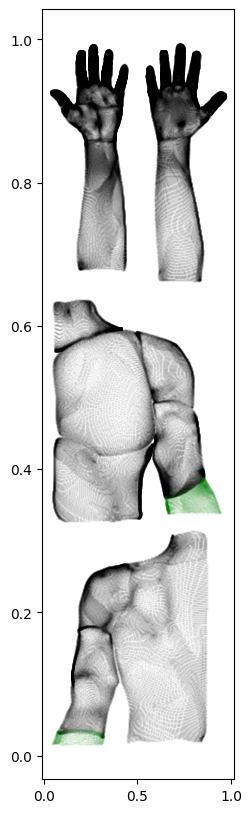

In [7]:
(base_uv_data, base_split_face_data) =\
    txt_to_dataframe("../Models/Adjusted Elbow",
                     "Male Left Base Map.txt")
(moved_uv_data, moved_split_face_data) =\
    txt_to_dataframe("../Models/Adjusted Elbow",
                     "Male Left Moved Elbow Map.txt")
(combined_uv_data, combined_lookup_data) =\
    create_combined_data((base_uv_data, base_split_face_data,),
                         [(moved_uv_data, moved_split_face_data,),])

In [8]:
def get_mesh_data(model_directory: str, obj_file: str,
                  uv_data: pl.DataFrame, lookup_table: pl.DataFrame) -> None:
    '''
    Saves out the mesh data from an obj file.

    Saves out the mesh verticies, mesh faces, the UV data, and the lookup table
    for finding the link between each UV point to a vertex on the 3D model.

    Parameters
    ----------
    model_directory : str
        The relative path to the folder that contains the UV mapped mesh files
        in obj and text format.
    obj_file : str
        The name of the obj mesh file.
    uv_data : pl.DataFrame
        Table of the UV mapping of the mesh.
    lookup_table
        Table of the connections between each UV point and mesh verticies.

    See Also
    --------
    create_combined_data :
        Takes separate UV maps and lookup tables and combines them.
    txt_to_dataframe :
        Parses 3D mesh file in text format into the UV data and face lookup
        table.

    Notes
    -----
    The OBJ mesh data is used to extract the vertex table and the mesh faces.
    The text file is used by the `txt_to_dataframe` method to find the UV data
    and the lookup table from each UV point to each vertex.
    '''

    # Read in the mesh into a vertex table and face table
    mesh_verticies, mesh_faces =\
        pp3d.read_mesh(f"{model_directory}/{obj_file}")

    # Convert the uv data and lookup table into numpy arrays
    uv_array = uv_data.drop("index").to_numpy()
    lookup_data = lookup_table.to_numpy()

    sex = obj_file.lower().split(' ')[0]
    side = obj_file.lower().split(' ')[1]
    # Save as a compressed npz file for import in the future.
    np.savez_compressed("../Data/" + sex + " " + side + " arm mesh data.npz",
                        mesh_verticies=mesh_verticies, mesh_faces=mesh_faces,
                        uv_array=uv_array, lookup_data=lookup_data)

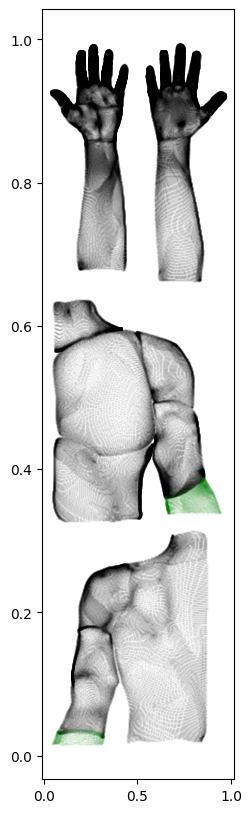

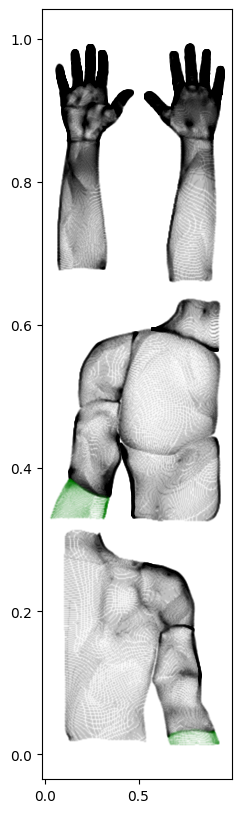

In [9]:
# Male Left Arm
(base_uv_data, base_split_face_data) =\
    txt_to_dataframe("../Models/Adjusted Elbow",
                     "Male Left Base Map.txt")
(moved_uv_data, moved_split_face_data) =\
    txt_to_dataframe("../Models/Adjusted Elbow",
                     "Male Left Moved Elbow Map.txt")
(combined_uv_data, combined_lookup_data) =\
    create_combined_data((base_uv_data, base_split_face_data,),
                         [(moved_uv_data, moved_split_face_data,),])
get_mesh_data("../Models/Adjusted Elbow", "Male Left Base Map.obj",
              combined_uv_data, combined_lookup_data)

(base_uv_data, base_split_face_data) =\
    txt_to_dataframe("../Models/Adjusted Elbow",
                     "Male Right Base Map.txt")
(moved_uv_data, moved_split_face_data) =\
    txt_to_dataframe("../Models/Adjusted Elbow",
                     "Male Right Moved Elbow Map.txt")
(combined_uv_data, combined_lookup_data) =\
    create_combined_data((base_uv_data, base_split_face_data,),
                         [(moved_uv_data, moved_split_face_data,),])
get_mesh_data("../Models/Adjusted Elbow", "Male Right Base Map.obj",
              combined_uv_data, combined_lookup_data)